<a href="https://colab.research.google.com/github/wandersomMv/Detector-de-faces/blob/master/c_digo_mestrado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import matplotlib library
import matplotlib.pyplot as plt
 
#* importação da biblioteca scikit-learn 
from sklearn.model_selection import train_test_split #*função para separar dados de teste e de treinamento
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people  #*função para buscar os dados 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA 
from sklearn.svm import SVC
 
import numpy as np

In [ ]:
# *este comando fará o download do conjunto de dados do LFW_people para o disco rígido.
lfw_people = fetch_lfw_people(min_faces_per_person = 70, resize = 0.4)
 
#* dimenções das matrizes de imagens para encontrar as formas (para plotagem)
n_samples, h, w = lfw_people.images.shape
 
#* Em vez de fornecer dados 2D, X já possui dados na forma de um vetor que é necessário nesta abordagem
X = lfw_people.data
n_features = X.shape[1]
 
#*o label para prever é o id da pessoa
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
 
#*Imprimir detalhes sobre o conjunto de dados
print(f"Número de amostras de dados {n_samples}")
print(f"Tamanho de uma amostra de dados: { n_features}")
print(f"Número de etiquetas de classe: {n_classes}")

Número de amostras de dados 1288
Tamanho de uma amostra de dados: 1850
Número de etiquetas de classe: 7


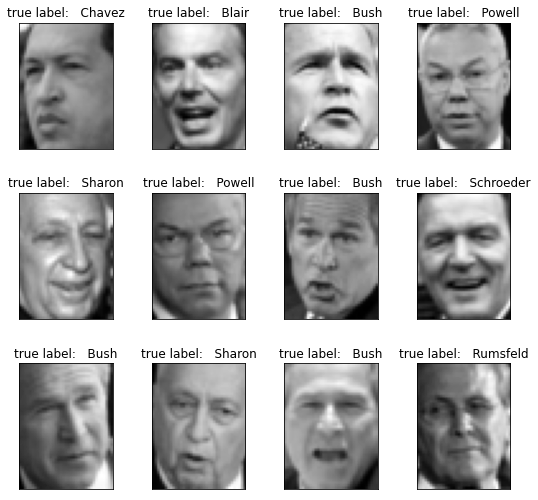

In [ ]:
#* Função para plotar imagens em 3*4
def plot_gallery(images, titles, h, w, n_row = 3, n_col = 4):
    plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom = 0, left =.01, right =.99, top =.90, hspace =.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap = plt.cm.gray)
        plt.title(titles[i], size = 12)
        plt.xticks(())
        plt.yticks(())
 
#* Função para gerar rótulos verdadeiros acima das imagensv
def true_title(Y, target_names, i):
    true_name = target_names[Y[i]].rsplit(' ', 1)[-1]
    return 'true label:   % s' % (true_name)
 
true_titles = [true_title(y, target_names, i)
                     for i in range(y.shape[0])]
plot_gallery(X, true_titles, h, w)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 42)
print(f"Tamanho dos dados de treinamento é { y_train.shape[0]} e de teste é {y_test.shape[0]}")

Tamanho dos dados de treinamento é 966 e de teste é 322


In [ ]:
from time import time
n_components = 150
 
t0 = time()
pca = PCA(n_components = n_components, svd_solver ='randomized',
          whiten = True).fit(X_train)
print(f"processado em  {(time() - t0):9.3f}s" )
 
eigenfaces = pca.components_.reshape((n_components, h, w))
 
print("Projetando os dados de entrada na base ortonormal de autofaces")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(f"processado em  {(time() - t0):9.3f}s")

processado em      0.218s
Projetando os dados de entrada na base ortonormal de autofaces
processado em      0.023s


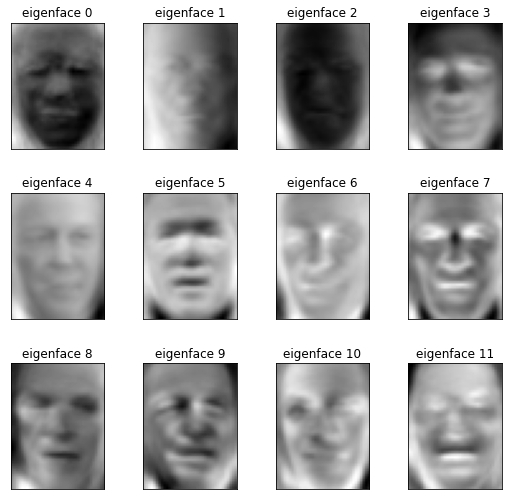

In [ ]:
#Plotar as eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

In [ ]:
print(f"Um ponto de dados de amostra após a aplicação do PCA: \n {X_train_pca[0]}")
print("-----------------------------------------------------")
print(f"Dimensões dos conjuntos de treinamento = {X_train.shape} s e de teste = {X_test.shape}")

Um ponto de dados de amostra após a aplicação do PCA: 
 [-2.0756001  -1.0457884   2.1269372   0.03681976 -0.7575718  -0.51736504
  0.85550684  1.051931    0.4577576   0.01347799 -0.03963045  0.6387254
  0.48167554  2.3378735   1.7784275   0.13309959 -2.2713137  -4.456921
  2.0977328  -1.1379229   0.1884433  -0.33499628  1.1254556  -0.3240356
  0.14095092  1.076948    0.758814   -0.09976355  3.1199532   0.88378495
 -0.89338106  1.1595815   1.4306957   1.6856345   1.3434452  -1.2591188
 -0.63913643 -2.3362854  -0.01359185 -1.4638717  -0.46899083 -1.0547949
 -1.3327886   1.1365188   2.2223628  -1.8014009  -0.30635482 -1.0282316
  4.7730775   3.4602275   1.9259624  -1.3513309  -0.2587382   2.01036
 -1.0561796   0.36104217  1.1709398   0.75714284  0.9004967   0.599309
 -0.4652046   2.0977685   1.3459848   1.933085    5.066456   -0.7045171
  0.60727894 -0.90023345 -0.21632807 -2.1074748  -1.6826143  -0.19882657
 -1.745225   -3.0564847   2.0518868   0.3940405   0.12780648  1.2076782
 -0.79554

In [ ]:
print("Ajustando o classificador ao conjunto de treinamento")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(
    SVC(kernel ='rbf', class_weight ='balanced'), param_grid
)
clf = clf.fit(X_train_pca, y_train)
print(f"processado em  {(time() - t0):9.3f}s" )
print("Melhor estimador encontrado pela pesquisa de grade:")
print(clf.best_estimator_)
 
print("Predição os nomes das pessoas no conjunto de testet")
t0 = time()
y_pred = clf.predict(X_test_pca)
print(f"processado em  {(time() - t0):9.3f}s" )
# imprimir resultados das classificação
print(classification_report(y_test, y_pred, target_names = target_names))
# imprimir matriz de confusão
print("Matriz de confusão:")
print(confusion_matrix(y_test, y_pred, labels = range(n_classes)))

Ajustando o classificador ao conjunto de treinamento
processado em     20.216s
Melhor estimador encontrado pela pesquisa de grade:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)
Predição os nomes das pessoas no conjunto de testet
processado em      0.081s
                   precision    recall  f1-score   support

     Ariel Sharon       0.86      0.46      0.60        13
     Colin Powell       0.76      0.87      0.81        60
  Donald Rumsfeld       0.94      0.63      0.76        27
    George W Bush       0.83      0.98      0.90       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       0.88      0.47      0.61        15
       Tony Blair       0.96      0.75      0.84        36

         accuracy                           0.84       322
        macro avg       0.88      0.71      0.77       322
     weighted avg       0.86      0.84      0.84       322

Matriz de confusão:
[[  6   3   0   4   0   0   0]
 [  1  52   0   6   0   1   0]
 [  0

Prevendo os nomes das pessoas no conjunto de teste
processado em      0.048s
                   precision    recall  f1-score   support

     Ariel Sharon       0.86      0.46      0.60        13
     Colin Powell       0.76      0.87      0.81        60
  Donald Rumsfeld       0.94      0.63      0.76        27
    George W Bush       0.83      0.98      0.90       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       0.88      0.47      0.61        15
       Tony Blair       0.96      0.75      0.84        36

         accuracy                           0.84       322
        macro avg       0.88      0.71      0.77       322
     weighted avg       0.86      0.84      0.84       322



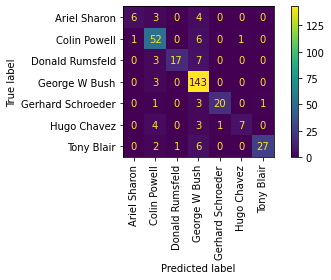

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
print("Prevendo os nomes das pessoas no conjunto de teste")
t0 = time()
y_pred = clf.predict(X_test_pca)
print(f"processado em  {(time() - t0):9.3f}s" )

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

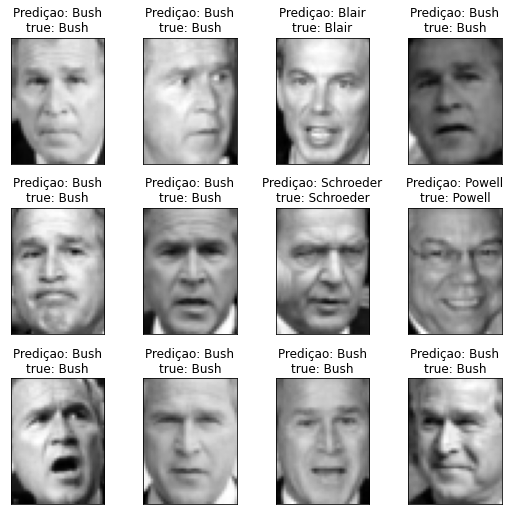

In [ ]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return f"Prediçao: {pred_name}\ntrue: {true_name}"


prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)